In [1]:
import pandas as pd
import numpy as np

from get_gene_info import get_genome_info, get_genes_from_ranges
from get_proteome_info import match_proteomic_data, calculate_proteomic_load
from plot_proteome import plot_perc_load, plot_distribution, plot_strain_distribution

In [2]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args, titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# Get deleted genes

Getting the genes that should be affected by the deleted ranges (Only for Delta 16 from MG1655 and all the W3110 strains as the others already report which genes are deleted)


#### MG1655

In [3]:

delta16 = pd.read_csv('../files/deleted_ranges/delta_16.csv',encoding='latin1')

genomeMG1655_path = '../files/genomes/MG1655.gb'
genomeMG1655 = get_genome_info(genomeMG1655_path)

delta_16_genes = get_genes_from_ranges(delta16, genomeMG1655)
delta_16_genes = delta_16_genes.drop_duplicates()
delta_16_genes.to_csv('../files/deleted_genes/mapped_del_genes_Δ16.csv',header=True)

1170


In [4]:
## Get files with the lengths of the genes from de MG1655

In [5]:
## Las MDS y MS56 ya traían sus bnumber, no hubo necesidad de mapear
#MS56
genes_MS56 = list(pd.read_csv('../files/deleted_ranges/MS56.csv')['Locus_Tag'])

#MDS
MDS_line = pd.read_csv('../files/deleted_ranges/MDS42_69.csv')
MD12v2 = pd.read_csv('../files/deleted_ranges/MDS12_V2.csv')
MDS_line= MDS_line.set_index('bnumber')
genes_12_v2=list(set(MD12v2['MDS12']))
genes_42 = list(set(MDS_line['MDS42_deleted'][MDS_line['MDS42_deleted']!=0].index))
genes_69 = list(set(MDS_line['MDS69_deleted'][MDS_line['MDS69_deleted']!=0].index))

In [6]:
strains_wbnumber = {'MS56':genes_MS56,'MDS12':genes_12_v2, 'MDS42':genes_42, 'MDS69':genes_69}

In [7]:
genes_finalesMG1655 = {}

for strain in strains_wbnumber.keys():
    genes_finalesMG1655[strain] = genomeMG1655.loc[genomeMG1655.Bnumber.isin(strains_wbnumber[strain]),['Bnumber', 'Gen', 'Length']]
    genes_finalesMG1655[strain] = genes_finalesMG1655[strain].drop_duplicates()
    genes_finalesMG1655[strain].to_csv('../files/deleted_genes/mapped_del_genes_'+strain+'.csv',header=True)

#### W3110

In [8]:
names_W3110 = ['DGF298', 'DGF327', 'MGF02', 'MGF01' ]

rangos = pd.read_csv('../files/deleted_ranges/MGF_line.csv',encoding='latin1')
genomeW3110_path = '../files/genomes/W3110.gb'
genomeW3110 = get_genome_info(genomeW3110_path)

strains = []

In [9]:
for name_W3110 in names_W3110:
    strains.append(rangos.loc[:,[name_W3110+'_L', name_W3110+'_R']].dropna())

In [10]:
genes_finalesW3110 = {}

for strain in strains:
    nombre = strain.columns[0].split('_')[0]
    genes_finalesW3110[nombre] = get_genes_from_ranges(strain, genomeW3110)
    genes_finalesW3110[nombre] = genes_finalesW3110[nombre].drop_duplicates()
    genes_finalesW3110[nombre].to_csv('../files/deleted_genes/mapped_del_genes_'+nombre+'.csv',header=True)    

1727
1392
1176
1035


In [11]:
range_ej_1 = delta16.head()
range_ej_2 = strains[0].head()
gene_ej_1 = genes_finalesMG1655['MS56'].head().set_index('Bnumber')
gene_ej_2 = genes_finalesW3110['DGF298'].head().set_index('Bnumber')

In [12]:
    display_side_by_side(range_ej_1, gene_ej_1, range_ej_2, gene_ej_2, titles=['Ranges MS56->','Genes MS56','Ranges ->','Genes']) 

,D16_L,D16_R
0,2947930,2962780
1,289030,366193
2,3542486,3572350
3,4619264,4637974
4,3533214,3552459
,Gen,Length
Bnumber,,
b0016,insL-1,1114
b0018,mokC,211
b0019,nhaA,1168


# Proteome mapping

In [13]:
proteomic_data = pd.read_excel("../files/proteome_Schmidt/Proteomic_data_fg.xlsx") #Datos en fg  de distintas condiciones
proteome_size = pd.read_excel("../files/proteome_Schmidt/Proteome_size.xlsx")

In [14]:
proteomic_data.iloc[0:5,0:5]

,Bnumber,Gene,Glucosa,LB,Glicerol + AA
0,b2836,aas,0.000845,0.001648,0.001316
1,b0185,accA,0.223594,0.465969,0.396601
2,b3255,accB,0.071193,0.168232,0.122404
3,b3256,accC,0.148113,0.437881,0.259203
4,b2316,accD,0.091758,0.190092,0.155012


In [15]:
proteome_size.iloc[:,0:5]

,Unnamed: 0,Glucosa,LB,Glicerol + AA,Acetato
0,Proteoma Total,243.195528,366.968242,326.553153,196.363377


In [16]:
# MG1655
names_MG1655 = ['Δ16', 'MS56', 'MDS69','MDS42','MDS12']
cepas_MG1655 = {}

for name_MG1655 in names_MG1655:
    strain_df = pd.read_csv("../files/deleted_genes/mapped_del_genes_"+name_MG1655+".csv")
    strain_df = strain_df.drop('Unnamed: 0', axis=1)
    cepas_MG1655[name_MG1655]=strain_df

In [17]:
## W3110
cepas_W3110 = {}

for name_W3110 in names_W3110:
    strain_df = pd.read_csv("../files/deleted_genes/mapped_del_genes_"+name_W3110+".csv")
    strain_df = strain_df.drop('Unnamed: 0', axis=1)
    cepas_W3110[name_W3110]=strain_df

In [18]:
    display_side_by_side(cepas_MG1655['MS56'].head(), cepas_W3110['DGF298'].head(), titles=['MG1655 (MS56)','W3110 (DGF298)']) 

,Bnumber,Gen,Length
0,b0016,insL-1,1114
1,b0018,mokC,211
2,b0019,nhaA,1168
3,b0020,nhaR,907
4,b0022,insA-1,277
,Bnumber,Gen,Length
0,b0714,nei,793
1,b0715,abrB,1048
2,b0716,ybgO,1063
3,b0717,ybgP,730


In [19]:
matched_genes_cepas_MG1655 = match_proteomic_data(names_MG1655, cepas_MG1655, proteomic_data)
matched_genes_cepas_W3110 = match_proteomic_data(names_W3110, cepas_W3110, proteomic_data)

In [20]:
    display_side_by_side(matched_genes_cepas_MG1655['MS56'].head().iloc[:,0:6], matched_genes_cepas_W3110['DGF298'].head().iloc[:,0:6], titles=['MG1655 (MS56)','W3110 (DGF298)']) 

,Bnumber,Gene,Gen NCBI,Length,Glucosa,LB
26,b3714,adeP,adeP,1339,0.007098,3.361445e-03
28,b1478,adhP,adhP,1012,0.001540,2.830379e-03
33,b1002,agp,agp,1243,0.037989,1.035732e-01
44,b0516,allC,allC,1237,0.000009,1.736672e-07
45,b0506,allR,allR,817,0.009976,8.665591e-03
,Bnumber,Gene,Gen NCBI,Length,Glucosa,LB
20,b4069,acs,acs,1960,0.118984,0.280561
21,b4067,actP,actP,1651,0.003972,0.011103
25,b3665,ade,ade,1768,0.000522,0.005758
26,b3714,adeP,yieG,1339,0.007098,0.003361


# Proteomic load 

In [21]:
prot_load_MG1655, prot_perc_MG1655 = calculate_proteomic_load(names_MG1655, matched_genes_cepas_MG1655, proteome_size  )
prot_load_W3110, prot_perc_W3110 = calculate_proteomic_load(names_W3110, matched_genes_cepas_W3110, proteome_size  )

In [22]:
prot_load = prot_load_MG1655+prot_load_W3110

In [23]:
prot_perc = prot_perc_MG1655+prot_perc_W3110

In [24]:
prot_load = (pd.concat(prot_load,axis=1))
prot_perc = (pd.concat(prot_perc,axis=0).T)

In [25]:
    display_side_by_side(prot_load.iloc[0:5,0::2], prot_perc.iloc[0:5,0::2], titles=['Proteome Load','Proteome Percentage']) 

,Δ16,MDS69,MDS12,DGF327,MGF01
Glucosa,20.429299,5.976414,1.760846,13.387407,9.758176
LB,29.830063,11.564342,1.707077,21.614665,13.103638
Glicerol + AA,28.959023,13.794031,2.207994,28.235209,13.582319
Acetato,25.791522,9.116245,1.721988,16.776233,13.2063
Fumarato,24.530995,8.501137,1.724558,19.209616,14.41106
,Δ16,MDS69,MDS12,DGF327,MGF01
Glucosa,8.40036,2.457452,0.724045,5.504791,4.012482
LB,8.128786,3.15132,0.465184,5.890064,3.570783
Glicerol + AA,8.868089,4.22413,0.676152,8.646436,4.159298
Acetato,13.134589,4.642538,0.87694,8.543463,6.725439


In [26]:
#new_order = ["LB","Glicerol + AA","42°C glucosa","Fructosa","pH6 glucosa",
#             "Glucosa","Estrés-osmótico glucosa","Xilosa","Quimiostato µ=0.5",
#             "Manosa","Glicerol","Glucosamina","Succinato","Fumarato","Piruvato",
#             "Quimiostato µ=0.35","Acetato","Galactosa","Quimiostato µ=0.20",
#             "Quimiostato µ=0.12","Fase estacionaria 1 día","Fase estacionaria 3 días"]

In [27]:
#plot_perc_load(prot_load, prot_perc, conditions = new_order, save=True, identifier='K12' )

Solo las del artículo

In [28]:
representative_conditions = ["LB","Fructosa", "Glucosa","Estrés-osmótico glucosa",
                             "Quimiostato µ=0.5", "Glicerol","Fumarato","Piruvato",
                             "Acetato","Galactosa", "Quimiostato µ=0.12","Fase estacionaria 1 día"]
representative_strains = ['Δ16', 'MS56', 'MDS69', 'DGF298', 'MGF02']

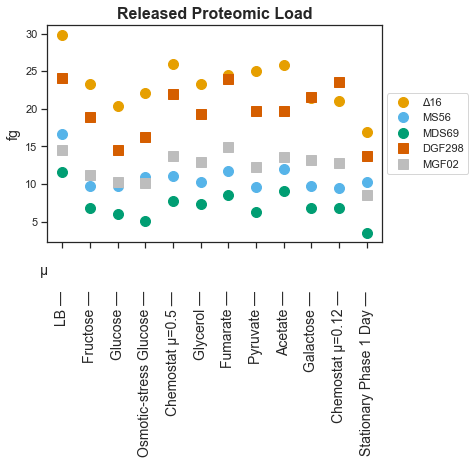

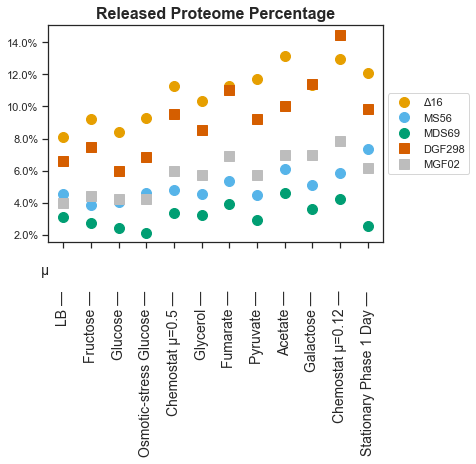

In [29]:
plot_perc_load(prot_load, prot_perc, conditions = representative_conditions,
               strains = representative_strains, save=True, identifier='K12' )

# Proteome distribution

In [30]:
distribucion_prot = pd.DataFrame({'Gen':proteomic_data.Bnumber,'Promedio':proteomic_data.iloc[:,2:24].T.mean(),'STD':proteomic_data.iloc[:,2:24].T.std()})

In [31]:
distribucion_prot = distribucion_prot.sort_values(by='Promedio',ascending=False).reset_index().drop(columns=['index'])

In [32]:
distribucion_prot.head()

,Gen,Promedio,STD
0,b3339,14.050141,6.025027
1,b4015,7.379211,5.911134
2,b0957,6.355356,1.664707
3,b3340,3.947647,2.130137
4,b2414,3.670652,1.389756


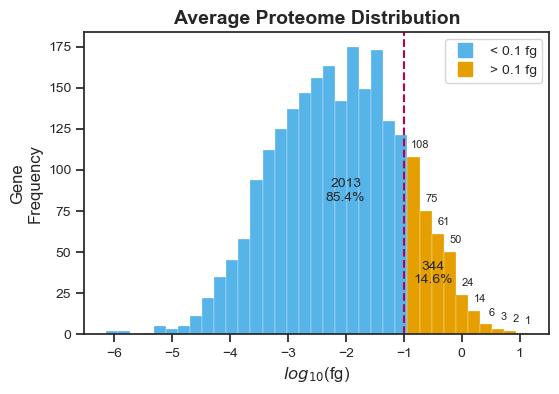

In [33]:
plot_distribution(distribucion_prot, 'Promedio', eng=True) # Cambiar distribución_prot por distribución_glc, y otras

In [34]:
distribucion_prot_glc = pd.DataFrame({'Gen':proteomic_data.Bnumber,'Glucosa':proteomic_data['Glucosa']})

In [35]:
distribucion_prot_glc = distribucion_prot_glc.loc[distribucion_prot_glc['Glucosa']>0] 

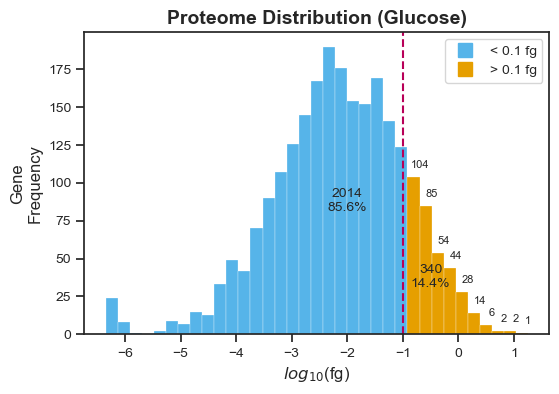

In [36]:
plot_distribution(distribucion_prot_glc , 'Glucosa', eng=True) 

# Proteome distribution Deleted Genes from Strains

In [37]:
distribucion_prot.head()

,Gen,Promedio,STD
0,b3339,14.050141,6.025027
1,b4015,7.379211,5.911134
2,b0957,6.355356,1.664707
3,b3340,3.947647,2.130137
4,b2414,3.670652,1.389756


In [38]:
genes_total = {}
for strain, info in matched_genes_cepas_W3110.items():
    genes_total[strain] = info.Bnumber
for strain, info in matched_genes_cepas_MG1655.items():
    genes_total[strain] = info.Bnumber


In [39]:
genes_total['DGF298'].head()

20    b4069
21    b4067
25    b3665
26    b3714
27    b1241
Name: Bnumber, dtype: object

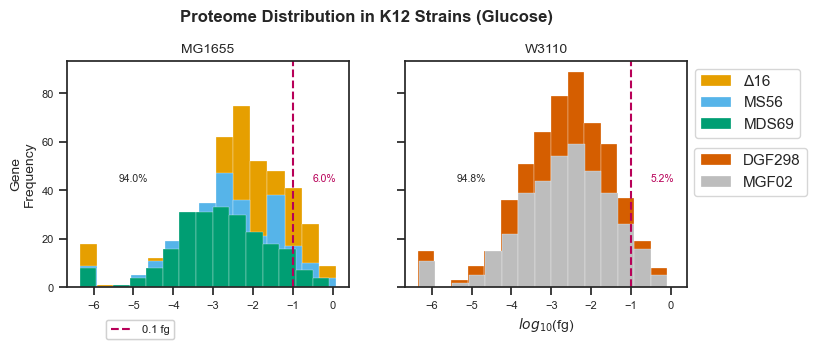

In [40]:
plot_strain_distribution(genes_total, distribucion_prot_glc, representative_strains,
                                 'K12', 'Glucosa', save=False, identifier='Multi_panel_dist_cepas_2' )